<a href="https://colab.research.google.com/github/Amirbn73/Air-Pollution-Prediction-PM2.5/blob/main/ANN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from time import time

In [47]:
file = files.upload()

Saving Final data.csv to Final data.csv


In [48]:
!git clone https://github.com/PetraVidnerova/rbf_keras.git

fatal: destination path 'rbf_keras' already exists and is not an empty directory.


In [49]:
from sklearn.model_selection import KFold
import keras
from keras import layers
import tensorflow
from rbf_keras import kmeans_initializer
from keras.optimizers import RMSprop

In [101]:
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np


class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
      assert shape[1] == self.X.shape[1]
      idx = np.random.randint(self.X.shape[0], size=shape[0])

	# type checking to access elements of data correctly
      if type(self.X) == np.ndarray:
          return self.X[idx, :]
      elif type(self.X) == pd.core.frame.DataFrame:
          return self.X.iloc[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```


    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [81]:
df = pd.read_csv('Final data.csv')

In [82]:
ds = pd.read_csv('Final data.csv')

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
ds.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Month,Dis2MR
0,10.008960,4.248512,1.643546,21.813877,8.060351,9.587247,2020.0,Jan,185.53975
1,10.008616,4.246932,1.643887,21.811733,8.058581,9.588584,2020.0,Jan,162.24980
2,10.008278,4.245368,1.644224,21.809600,8.056815,9.589995,2020.0,Jan,142.30249
3,10.007943,4.243823,1.644559,21.807484,8.055056,9.591481,2020.0,Jan,127.27922
4,10.007614,4.242294,1.644889,21.805378,8.053301,9.593042,2020.0,Jan,100.62306


In [85]:
# Create dummy variables for the 'Month' column with drop_first=True
df_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, df_dummies], axis=1)

# Drop the original 'Month' column since we now have dummy variables
df = df.drop('Month', axis=1)

df.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,10.008960,4.248512,1.643546,21.813877,8.060351,9.587247,2020.0,185.53975,0,0,0,1,0,0,0,0,0,0,0
1,10.008616,4.246932,1.643887,21.811733,8.058581,9.588584,2020.0,162.24980,0,0,0,1,0,0,0,0,0,0,0
2,10.008278,4.245368,1.644224,21.809600,8.056815,9.589995,2020.0,142.30249,0,0,0,1,0,0,0,0,0,0,0
3,10.007943,4.243823,1.644559,21.807484,8.055056,9.591481,2020.0,127.27922,0,0,0,1,0,0,0,0,0,0,0
4,10.007614,4.242294,1.644889,21.805378,8.053301,9.593042,2020.0,100.62306,0,0,0,1,0,0,0,0,0,0,0


In [87]:
# Create dummy variables for the 'Month' column with drop_first=True
ds_dummies = pd.get_dummies(ds['Month'], prefix='Month', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
ds = pd.concat([ds, ds_dummies], axis=1)

# Drop the original 'Month' column since we now have dummy variables
ds = ds.drop('Month', axis=1)

ds.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,10.008960,4.248512,1.643546,21.813877,8.060351,9.587247,2020.0,185.53975,0,0,0,1,0,0,0,0,0,0,0
1,10.008616,4.246932,1.643887,21.811733,8.058581,9.588584,2020.0,162.24980,0,0,0,1,0,0,0,0,0,0,0
2,10.008278,4.245368,1.644224,21.809600,8.056815,9.589995,2020.0,142.30249,0,0,0,1,0,0,0,0,0,0,0
3,10.007943,4.243823,1.644559,21.807484,8.055056,9.591481,2020.0,127.27922,0,0,0,1,0,0,0,0,0,0,0
4,10.007614,4.242294,1.644889,21.805378,8.053301,9.593042,2020.0,100.62306,0,0,0,1,0,0,0,0,0,0,0


In [88]:
# ds.drop(['Year', 'Month'], axis = 1, inplace = True)

In [89]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import keras

In [90]:
ds.describe()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
count,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1380456.0,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06,1.380456e+06
mean,1.612860e+01,7.596534e+00,1.892585e+00,1.992760e+01,6.355540e+00,8.244152e+00,2020.5,3.396983e+02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02,8.333333e-02
std,5.615865e+00,4.284394e+00,1.139647e+00,3.176495e+00,1.544165e+00,2.400356e+00,0.5,2.716289e+02,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01,2.763855e-01
min,6.916730e+00,1.083853e+00,5.806452e-02,1.446667e+01,3.400001e+00,3.709709e+00,2020.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.116879e+01,3.817965e+00,1.274608e+00,1.815804e+01,5.285732e+00,6.637001e+00,2020.0,1.272792e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.570219e+01,6.529569e+00,1.685832e+00,1.949477e+01,6.173952e+00,7.821862e+00,2020.5,2.700000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.187687e+01,1.241050e+01,2.678683e+00,2.098812e+01,7.159811e+00,9.483219e+00,2021.0,5.031153e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.554397e+01,1.557952e+01,5.219355e+00,3.346843e+01,1.407894e+01,1.458621e+01,2021.0,1.412312e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [91]:
scaler = MinMaxScaler((0,1))
ds['Maximum_Air_Temperature'] = scaler.fit_transform(ds[['Maximum_Air_Temperature']])
ds['Minimum_Air_Temperature'] = scaler.fit_transform(ds[['Minimum_Air_Temperature']])
ds['Rainfall_Total'] = scaler.fit_transform(ds[['Rainfall_Total']])
ds['Maximum_Gust_Speed'] = scaler.fit_transform(ds[['Maximum_Gust_Speed']])
ds['Mean_Wind_Speed'] = scaler.fit_transform(ds[['Mean_Wind_Speed']])
# ds['PM2_5'] = scaler.fit_transform(ds[['PM2_5']])
ds['Dis2MR'] = scaler.fit_transform(ds[['Dis2MR']])

In [92]:
X = ds.drop(['PM2_5','Year'],axis = 1)
y = ds[['PM2_5']]

In [93]:
from sklearn.utils import shuffle

In [94]:
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

In [95]:
print(X_shuffled.shape,y_shuffled.shape)
X_shuffled.head()

(1380456, 17) (1380456, 1)


,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
411173,0.975431,0.964530,0.390780,0.229946,0.152226,0.063725,1,0,0,0,0,0,0,0,0,0,0
1172290,0.808802,0.780069,0.371926,0.007391,0.016767,0.045061,0,0,0,0,0,0,0,0,0,0,1
1093245,0.778028,0.823630,0.310571,0.174732,0.226824,0.433379,1,0,0,0,0,0,0,0,0,0,0
1075565,0.922770,0.941029,0.399917,0.228490,0.270198,0.142494,0,0,0,0,1,0,0,0,0,0,0
761577,0.134185,0.120445,0.276534,0.261925,0.206757,0.701702,0,0,1,0,0,0,0,0,0,0,0


In [96]:
y_shuffled.head()

,PM2_5
411173,8.455785
1172290,10.147978
1093245,6.473287
1075565,8.288225
761577,10.107923


In [97]:
X_tr, X_test, y_tr, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.1, random_state=42)

In [98]:
X_test.shape

(138046, 17)

In [99]:
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.1, random_state=42)

In [107]:
# kfold = KFold(n_splits = 1)
histories = []
rbfLayer = RBFLayer(10,
                      initializer= kmeans_initializer.InitCentersKMeans(X_shuffled),
                      betas = 2.0,
                      input_shape = ([17]))
ins_model = keras.models.Sequential()
ins_model.add(rbfLayer)
ins_model.add(layers.Dense(1))
ins_model.compile(loss = 'mae',
                    optimizer = RMSprop())
i = 0
history = ins_model.fit(X_train, y_train,
                          epochs = 500,
                          batch_size = 1024,
                          validation_data = (X_val, y_val)
                          )
histories.append(history)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/500
1092/1092 [==============================] - 6s 5ms/step - loss: 6.1730 - val_loss: 3.2136
Epoch 2/500
1092/1092 [==============================] - 7s 6ms/step - loss: 1.3349 - val_loss: 0.9310
Epoch 3/500
1092/1092 [==============================] - 5s 5ms/step - loss: 0.8793 - val_loss: 0.8355
Epoch 4/500
1092/1092 [==============================] - 7s 6ms/step - loss: 0.8083 - val_loss: 0.7859
Epoch 5/500
1092/1092 [==============================] - 7s 6ms/step - loss: 0.7709 - val_loss: 0.7565
Epoch 6/500
1092/1092 [==============================] - 6s 6ms/step - loss: 0.7455 - val_loss: 0.7393
Epoch 7/500
1092/1092 [==============================] - 6s 5ms/step - loss: 0.7254 - val_loss: 0.7149
Epoch 8/500
1092/1092 [==============================] - 6s 5ms/step - loss: 0.7022 - val_loss: 0.6811
Epoch 9/500
1092/1092 [==============================] - 6s 6ms/step - loss: 0.6603 - val_loss: 0.6404
Epoch 10/500
1092/1092 [==============================] - 5s 5ms/step - l

In [108]:
y_pred = ins_model.predict(X_test,
                           batch_size = 2048)
r2_score(y_test, y_pred)

68/68 [==============================] - 0s 4ms/step


0.9689818990383381

In [109]:
mean_squared_error(y_test, y_pred)

0.17968530385999545

In [110]:
mean_absolute_error(y_test, y_pred)

0.26031906097303154

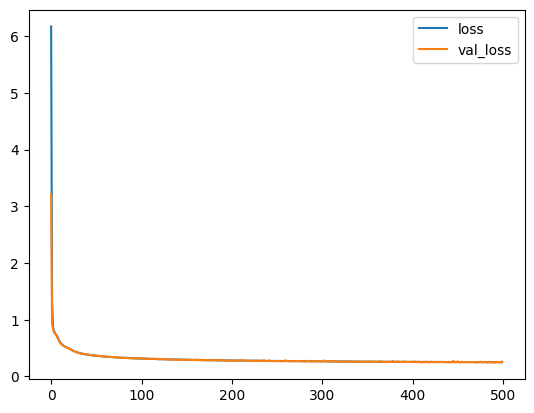

In [111]:
for i in histories:
  pd.DataFrame(i.history).plot()

In [113]:
correlation_matrix = ds.corr()

# Display the correlation matrix
correlation_matrix

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
Maximum_Air_Temperature,1.000000,0.945892,-0.103572,-0.293747,-0.250654,-0.286125,-1.092736e-01,-8.092701e-04,3.884200e-01,-3.656416e-01,-3.218884e-01,-4.046496e-01,4.045848e-01,3.332936e-01,-2.196949e-01,1.356084e-01,-2.148624e-01,-7.622682e-03,3.039600e-01
Minimum_Air_Temperature,0.945892,1.000000,0.094351,-0.285270,-0.215204,-0.416539,-5.572845e-02,-3.626572e-04,4.607877e-01,-2.495803e-01,-2.900721e-01,-3.361888e-01,4.242723e-01,3.453155e-01,-2.757634e-01,-1.336770e-03,-1.929528e-01,7.719194e-02,2.892577e-01
Rainfall_Total,-0.103572,0.094351,1.000000,0.322483,0.193382,-0.387278,1.504534e-02,8.680301e-04,-1.495569e-02,1.183715e-01,1.494715e-01,1.540001e-01,5.141942e-03,8.426855e-02,-1.988164e-01,-1.297957e-01,-2.647598e-01,5.656108e-01,-1.624044e-01
Maximum_Gust_Speed,-0.293747,-0.285270,0.322483,1.000000,0.884160,-0.230964,-3.959544e-01,1.377099e-02,-8.330539e-02,-5.201372e-02,5.593494e-01,-1.733160e-02,-1.169411e-01,-1.724515e-01,2.117341e-01,1.327537e-01,-2.097416e-01,1.215307e-01,-2.460174e-01
Mean_Wind_Speed,-0.250654,-0.215204,0.193382,0.884160,1.000000,-0.185274,-2.978353e-01,3.069866e-02,-5.148156e-02,-3.534144e-02,5.014942e-01,9.985969e-03,-9.181076e-02,-1.065275e-01,1.944471e-01,1.613623e-02,-1.546447e-01,2.077283e-02,-1.662707e-01
PM2_5,-0.286125,-0.416539,-0.387278,-0.230964,-0.185274,1.000000,7.112859e-02,1.374893e-02,-2.450636e-01,-1.228257e-01,-7.689801e-03,1.312156e-01,-2.275232e-01,-1.180192e-01,2.978740e-01,-1.543908e-01,2.625873e-01,-3.311833e-01,1.344893e-02
Year,-0.109274,-0.055728,0.015045,-0.395954,-0.297835,0.071129,1.000000e+00,2.926957e-13,-1.046419e-11,-7.164065e-12,3.110498e-12,3.670036e-12,-4.399481e-12,2.120556e-12,9.900402e-12,1.170934e-11,-4.992992e-12,-8.735944e-12,-7.457424e-12
Dis2MR,-0.000809,-0.000363,0.000868,0.013771,0.030699,0.013749,2.926957e-13,1.000000e+00,4.543180e-16,-2.939745e-15,-6.026153e-16,-4.271224e-16,3.923845e-16,1.595676e-15,7.690275e-16,3.033388e-15,-1.963258e-15,-2.179069e-15,-9.571257e-16
Month_Aug,0.388420,0.460788,-0.014956,-0.083305,-0.051482,-0.245064,-1.046419e-11,4.543180e-16,1.000000e+00,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02
Month_Dec,-0.365642,-0.249580,0.118371,-0.052014,-0.035341,-0.122826,-7.164065e-12,-2.939745e-15,-9.090909e-02,1.000000e+00,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02,-9.090909e-02


In [114]:
filtered_df = correlation_matrix[correlation_matrix > 0.5]

# Display the filtered DataFrame
filtered_df

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
Maximum_Air_Temperature,1.000000,0.945892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Minimum_Air_Temperature,0.945892,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rainfall_Total,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.565611,NaN
Maximum_Gust_Speed,NaN,NaN,NaN,1.000000,0.884160,NaN,NaN,NaN,NaN,NaN,0.559349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mean_Wind_Speed,NaN,NaN,NaN,0.884160,1.000000,NaN,NaN,NaN,NaN,NaN,0.501494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PM2_5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dis2MR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Aug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_Dec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
df.shape

(1380456, 19)

In [126]:
scaler = MinMaxScaler((0,1))
df['Maximum_Air_Temperature'] = scaler.fit_transform(df[['Maximum_Air_Temperature']])
df['Minimum_Air_Temperature'] = scaler.fit_transform(df[['Minimum_Air_Temperature']])
df['Rainfall_Total'] = scaler.fit_transform(df[['Rainfall_Total']])
df['Maximum_Gust_Speed'] = scaler.fit_transform(df[['Maximum_Gust_Speed']])
df['Mean_Wind_Speed'] = scaler.fit_transform(df[['Mean_Wind_Speed']])
# ds['PM2_5'] = scaler.fit_transform(ds[['PM2_5']])
df['Dis2MR'] = scaler.fit_transform(df[['Dis2MR']])

In [127]:
df

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,PM2_5,Year,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0.166006,0.218318,0.307187,0.386659,0.436406,9.587247,2020.0,0.131373,0,0,0,1,0,0,0,0,0,0,0
1,0.165987,0.218209,0.307253,0.386547,0.436240,9.588584,2020.0,0.114882,0,0,0,1,0,0,0,0,0,0,0
2,0.165969,0.218101,0.307318,0.386434,0.436075,9.589995,2020.0,0.100759,0,0,0,1,0,0,0,0,0,0,0
3,0.165951,0.217994,0.307383,0.386323,0.435910,9.591481,2020.0,0.090121,0,0,0,1,0,0,0,0,0,0,0
4,0.165934,0.217889,0.307447,0.386212,0.435746,9.593042,2020.0,0.071247,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380451,0.170436,0.250451,0.408731,0.233587,0.202307,7.298273,2021.0,0.351934,0,1,0,0,0,0,0,0,0,0,0
1380452,0.170440,0.250392,0.408717,0.233417,0.201982,7.299370,2021.0,0.383677,0,1,0,0,0,0,0,0,0,0,0
1380453,0.170444,0.250335,0.408703,0.233250,0.201664,7.300482,2021.0,0.414214,0,1,0,0,0,0,0,0,0,0,0
1380454,0.170448,0.250279,0.408689,0.233087,0.201353,7.301610,2021.0,0.443795,0,1,0,0,0,0,0,0,0,0,0


In [128]:
# Select independent variables (features) and dependent variable
X = df.drop(['Year','PM2_5'], axis = 1)
y = df['PM2_5']

In [129]:
from sklearn.utils import shuffle

In [130]:
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

In [131]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42)

In [132]:
from sklearn.neural_network import MLPRegressor

In [135]:
# del model

In [136]:
model = MLPRegressor(hidden_layer_sizes=(200,100,70,20), learning_rate = 'adaptive', verbose = True, max_iter=10, random_state=42)

In [137]:
begin = time()
model.fit(X_train, y_train)
end = time()
elapsed_time = end-begin
print(f'the model was run is {elapsed_time} seconds')

Iteration 1, loss = 0.27489390
Iteration 2, loss = 0.04270316
Iteration 3, loss = 0.03784543
Iteration 4, loss = 0.03406003
Iteration 5, loss = 0.03140248
Iteration 6, loss = 0.02944971
Iteration 7, loss = 0.02805213
Iteration 8, loss = 0.02682467
Iteration 9, loss = 0.02618796
Iteration 10, loss = 0.02485346
the model was run is 1083.8689105510712 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [139]:
# Create an instance of MLPRegressor
mlp = MLPRegressor(max_iter=10, verbose=True)

time1 = time()
# Training loop
for i in range(mlp.max_iter):
    start_time = time()

    # Train the model for one iteration
    mlp.partial_fit(X_train, y_train)

    end_time = time()
    elapsed_time = end_time - start_time

    print(f"Iteration {i + 1}: Elapsed time = {elapsed_time} seconds")
time2 = time()
time2-time1

Iteration 1, loss = 0.94278788
Iteration 1: Elapsed time = 6.089723348617554 seconds
Iteration 2, loss = 0.08016327
Iteration 2: Elapsed time = 8.584509134292603 seconds
Iteration 3, loss = 0.05659173
Iteration 3: Elapsed time = 6.569544553756714 seconds
Iteration 4, loss = 0.05166996
Iteration 4: Elapsed time = 9.70032024383545 seconds
Iteration 5, loss = 0.04862328
Iteration 5: Elapsed time = 9.284772634506226 seconds
Iteration 6, loss = 0.04673053
Iteration 6: Elapsed time = 8.016086339950562 seconds
Iteration 7, loss = 0.04505892
Iteration 7: Elapsed time = 10.41679859161377 seconds
Iteration 8, loss = 0.04368646
Iteration 8: Elapsed time = 10.326076030731201 seconds
Iteration 9, loss = 0.04240874
Iteration 9: Elapsed time = 9.12102746963501 seconds
Iteration 10, loss = 0.04122533
Iteration 10: Elapsed time = 11.219823837280273 seconds


89.33830285072327

In [140]:
mlp.score(X_test, y_test)

0.9862269179195358

In [141]:
model.score(X_test, y_test)

0.992253896127369

In [143]:
y_pred = mlp.predict(X_test)

In [144]:
X_test.head()

,Maximum_Air_Temperature,Minimum_Air_Temperature,Rainfall_Total,Maximum_Gust_Speed,Mean_Wind_Speed,Dis2MR,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
942058,0.513955,0.417793,0.526325,0.478771,0.401374,0.320216,0,0,0,0,0,0,0,1,0,0,0
375706,0.888716,0.816276,0.218165,0.295653,0.323228,0.031863,0,0,0,0,1,0,0,0,0,0,0
103605,0.219828,0.207240,0.665948,0.880408,0.689427,0.242659,0,0,1,0,0,0,0,0,0,0,0
611113,0.317903,0.322402,0.271289,0.232336,0.226781,0.045061,0,0,0,0,0,0,0,0,1,0,0
1097675,0.778050,0.819146,0.297395,0.132771,0.139674,0.541665,1,0,0,0,0,0,0,0,0,0,0


In [145]:
T = pd.DataFrame(y_test)
N = T.reset_index()
N.loc[100000]

index    491087.00000
PM2_5         7.33288
Name: 100000, dtype: float64

In [146]:
y_pred[100000]

7.249267882714298

In [148]:
mean_squared_error(y_test, y_pred)

0.07958184070518504